## Random Forest Classifier

In [2]:
import pandas as pd

# Import data
train = pd.read_csv("../data/train.csv").sort_values('id')
train_df = train.loc[:, train.columns != 'price']
train_prices = train['price'].values

test_df = pd.read_csv("../data/test.csv").sort_values('id')

In [56]:
from data_processing import preprocessing

# Combine data for processing (important for one-hot encoding)
combined_df = pd.concat([test_df, train_df], ignore_index=True)

# Select which columns to include in the analysis
selected_features = list(combined_df.columns)
to_remove = ['id', 'scrape_id', 'last_scraped', 'name', 'description', 
             'picture_url', 'host_id', 'host_name', 'calendar_last_scraped',
             'bathrooms_text']
for col in to_remove:
  selected_features.remove(col)

# Process combined data
processed_data = preprocessing(combined_df.copy(), selected_features)

test_processed = processed_data.iloc[:len(test_df)]
train_processed = processed_data.iloc[len(test_df):]

### Testing parameters with 5-fold CV and grid search

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_processed, train_prices, test_size=0.2)

# Remove rows with NaN values from X_train and y_train
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train.index.isin(X_train_clean.index)]

# Remove rows with NaN values from X_val and y_val
X_val_clean = X_val.dropna()
y_val_clean = y_val[X_val.index.isin(X_val_clean.index)]

In [43]:
from sklearn.model_selection import GridSearchCV

# Clean data
X = train_processed.copy()
y = train_prices.copy()

X_clean = X.dropna()
y_clean = y[X.index.isin(X_clean.index)]

# Define the parameter grid to search
candidates = [10, 30, 50, 100, 150, 200, 300, 400, 500]
param_grid = {'n_estimators': candidates}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Use GridSearchCV to perform 5-way cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_clean, y_clean)

# Get the results of the cross-validation
cv_results = grid_search.cv_results_

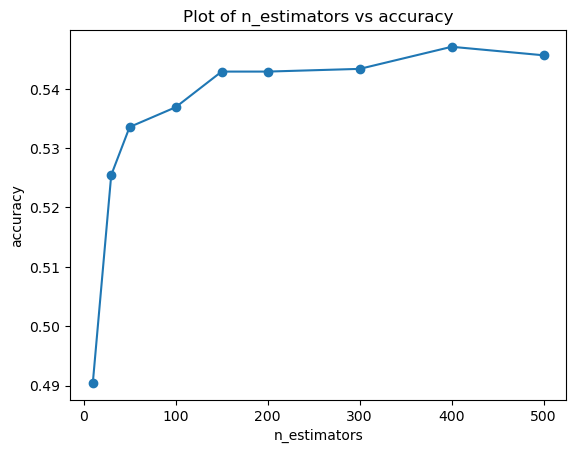

In [45]:
# Plot of accuracy vs n_estimators
import matplotlib.pyplot as plt

# Plot the relationship with lines
plt.plot(candidates, cv_results['mean_test_score'], marker='o', linestyle='-')

# Customize the plot
plt.title('Plot of n_estimators vs accuracy')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

# Show the plot
plt.show()

In [47]:
# Testing parameters, other than n_estimators

# Clean data
X = train_processed.copy()
y = train_prices.copy()

X_clean = X.dropna()
y_clean = y[X.index.isin(X_clean.index)]

# Define the parameter grid to search
param_grid = {'n_estimators': [150],
              'max_depth': [3, 5, None],
              'max_features': ['sqrt', None]}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Use GridSearchCV to perform 5-way cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_clean, y_clean)

# Get the results of the cross-validation
cv_results = grid_search.cv_results_

In [49]:
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Accuracy: {mean_score:.4f} (+/- {std_score:.4f}) for params: {params}")

Accuracy: 0.3996 (+/- 0.0033) for params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 150}
Accuracy: 0.4093 (+/- 0.0046) for params: {'max_depth': 3, 'max_features': None, 'n_estimators': 150}
Accuracy: 0.4490 (+/- 0.0046) for params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150}
Accuracy: 0.4590 (+/- 0.0027) for params: {'max_depth': 5, 'max_features': None, 'n_estimators': 150}
Accuracy: 0.5422 (+/- 0.0050) for params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 150}
Accuracy: 0.5403 (+/- 0.0095) for params: {'max_depth': None, 'max_features': None, 'n_estimators': 150}


### Fit Random Forest on full train data

In [57]:
# Use all data to train
X_train = train_processed
y_train = train_prices

# Remove rows with NaN values from X_train and y_train
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train.index.isin(X_train_clean.index)]

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=500)

# Train the classifier on the training data
random_forest.fit(X_train_clean, y_train_clean)

RandomForestClassifier(n_estimators=500)

In [37]:
X_test = test_processed.copy()

# Remove rows with NaN values from X_train
X_test_clean = X_test.dropna()

# Predict on the cleaned test data
predictions = random_forest.predict(X_test_clean)

# Fill back in missing predictions
included = X_test.index.isin(X_test_clean.index)
full_predictions = []
pred_idx = 0
for idx in range(len(X_test)):
    if included[idx]:
        full_predictions.append(predictions[pred_idx])
        pred_idx += 1
    else:
        full_predictions.append(0)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({'id': X_test.index, 'price': full_predictions})

In [58]:
from sklearn.impute import SimpleImputer

X_test = test_processed.copy()

# Save the original indices for later use
original_indices = X_test.index

# Impute missing values in X_test_full
imputer = SimpleImputer(strategy='median')
X_test_filled = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

# Predict on the cleaned test data
predictions_median = random_forest.predict(X_test_filled)

predictions_median_df = pd.DataFrame({'id': original_indices, 'price': predictions_median})

In [59]:
# Save predictions to output file
predictions_median_df.to_csv('../predictions/rf_500_median4.csv', index=False)